# Load R Packages 

In [2]:
install.packages(c("dplyr", "dtplyr", "data.table", "lubridate", 
"ggplot2", "PerformanceAnalytics", "xts"))

ERROR: Error in readRDS(dest): error reading from connection


In [ ]:
#| warning: false
library(dplyr)
library(dtplyr)
library(data.table)
library(lubridate)
library(ggplot2)
library(PerformanceAnalytics)
library(xts)

options(repr.plot.width = 10, repr.plot.height = 5)  # For Jupyter notebooks

In [ ]:
df <- fread("/Users/ivanhung/Documents/GitHub/final-r-assignment/dataset.csv")

# Cleaning dataset 

datadate,cshtrd,prccd,prchd,prcld,prcod
<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2010-01-04,52074710,18.93,18.94,18.235,18.27
2010-01-05,43368460,18.66,18.93,18.550,18.92
2010-01-06,41405070,18.60,18.81,18.510,18.66
2010-01-07,39427720,18.53,18.67,18.460,18.64
2010-01-08,30403370,18.68,18.71,18.520,18.62
2010-01-11,32442710,18.83,18.95,18.670,18.83


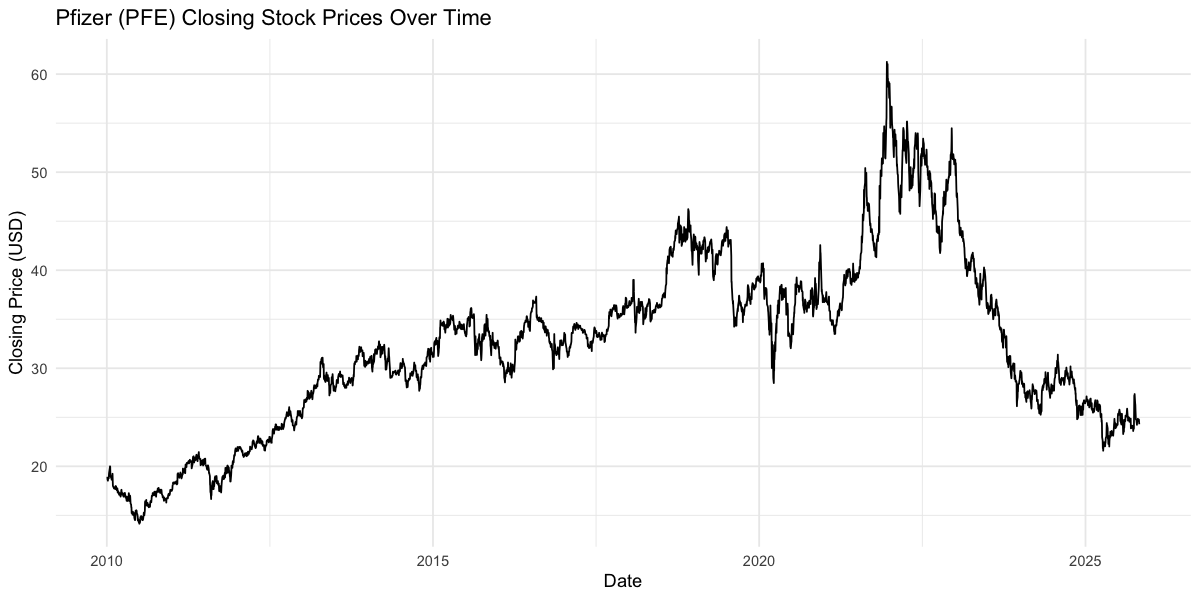

In [ ]:
# Setting datadate to a date object
df %>% mutate(datadate = as.Date(datadate, format = "%m/%d/%Y")) -> df

# Remove irrelevant columns and other stocks except for Pfizer (PFE)
pfe <- df[tic == "PFE",
          .(datadate, cshtrd, prccd, prchd, prcld, prcod)]

head(pfe)

# Plot time series of PFE's closing prices 
ggplot(data = pfe, aes(x = datadate, y = prccd)) +
  geom_line() +
  labs(title = "Pfizer (PFE) Closing Stock Prices Over Time",
       x = "Date",
       y = "Closing Price (USD)") +
  theme_minimal()


Next, calculate simple returns so that we can make our prices stationary and allow us to have a better understanding our data as we can proceed to plot Pfizer's ACF and PACF plots and confirm for certain statistical characteristics.

In [ ]:
# Calculating simple returns (simple returns in %), 
# which we will denote as s_ret (s_ret_per) 

pfe <- pfe %>%
    mutate(ret = round(((prccd/lag(prccd))-1), 4)) %>%
    mutate(s_ret = round(((prccd/lag(prccd))-1)*100, 4))
    
head(pfe)

datadate,cshtrd,prccd,prchd,prcld,prcod,ret,s_ret
<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2010-01-04,52074710,18.93,18.94,18.235,18.27,NA,NA
2010-01-05,43368460,18.66,18.93,18.550,18.92,-0.0143,-1.4263
2010-01-06,41405070,18.60,18.81,18.510,18.66,-0.0032,-0.3215
2010-01-07,39427720,18.53,18.67,18.460,18.64,-0.0038,-0.3763
2010-01-08,30403370,18.68,18.71,18.520,18.62,0.0081,0.8095
2010-01-11,32442710,18.83,18.95,18.670,18.83,0.0080,0.8030


Next, we should plot the autocorrelation and partial-autocorrelation functions of our closing prices to identify if there are any seasonal structures or autocorrelation that we might need to deal with.

Warning message in plot.window(...):
“"lags" is not a graphical parameter”
Warning message in plot.xy(xy, type, ...):
“"lags" is not a graphical parameter”
Warning message in axis(side = side, at = at, labels = labels, ...):
“"lags" is not a graphical parameter”
Warning message in axis(side = side, at = at, labels = labels, ...):
“"lags" is not a graphical parameter”
Warning message in box(...):
“"lags" is not a graphical parameter”
Warning message in title(...):
“"lags" is not a graphical parameter”
Warning message in plot.xy(xy, type, ...):
“"lags" is not a graphical parameter”
Warning message in axis(side = side, at = at, labels = labels, ...):
“"lags" is not a graphical parameter”
Warning message in axis(side = side, at = at, labels = labels, ...):
“"lags" is not a graphical parameter”
Warning message in box(...):
“"lags" is not a graphical parameter”
Warning message in title(...):
“"lags" is not a graphical parameter”


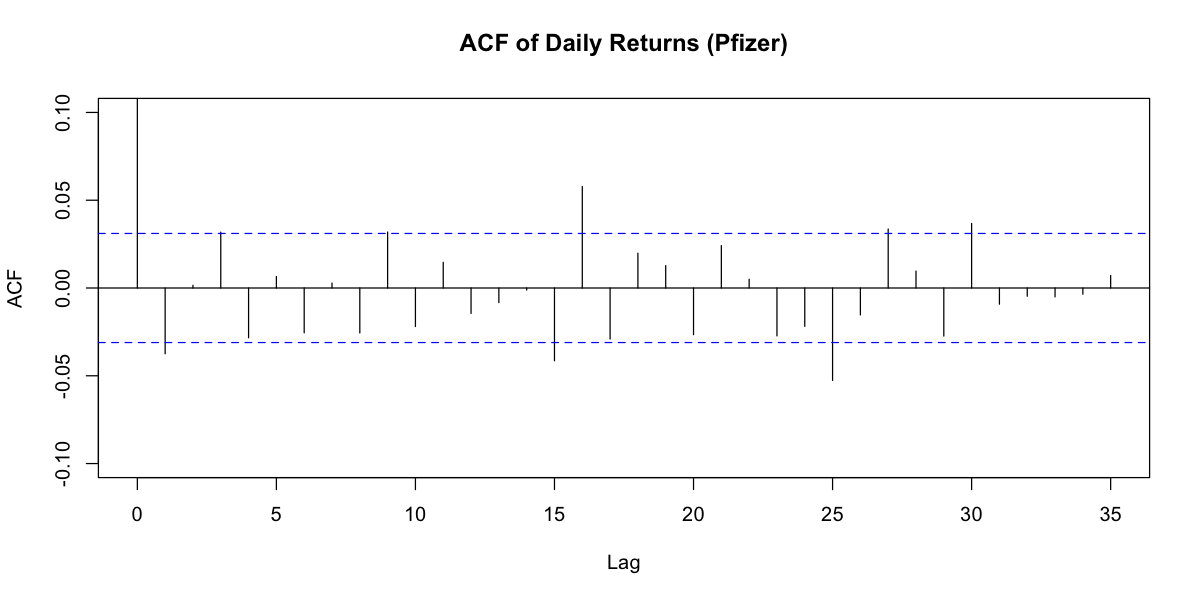

In [ ]:
# ACF plot to identify any autocorrelation or seasonality patterns in our data
#| warning: false
#| results: hide
acf(pfe$ret, lags = 20, 
    na.action = na.omit, 
    main = "ACF of Daily Returns (Pfizer)",
    ylim = c(-0.1,0.1))

Warning message in plot.window(...):
“"lags" is not a graphical parameter”
Warning message in plot.xy(xy, type, ...):
“"lags" is not a graphical parameter”
Warning message in axis(side = side, at = at, labels = labels, ...):
“"lags" is not a graphical parameter”
Warning message in axis(side = side, at = at, labels = labels, ...):
“"lags" is not a graphical parameter”
Warning message in box(...):
“"lags" is not a graphical parameter”
Warning message in title(...):
“"lags" is not a graphical parameter”
Warning message in plot.xy(xy, type, ...):
“"lags" is not a graphical parameter”
Warning message in axis(side = side, at = at, labels = labels, ...):
“"lags" is not a graphical parameter”
Warning message in axis(side = side, at = at, labels = labels, ...):
“"lags" is not a graphical parameter”
Warning message in box(...):
“"lags" is not a graphical parameter”
Warning message in title(...):
“"lags" is not a graphical parameter”


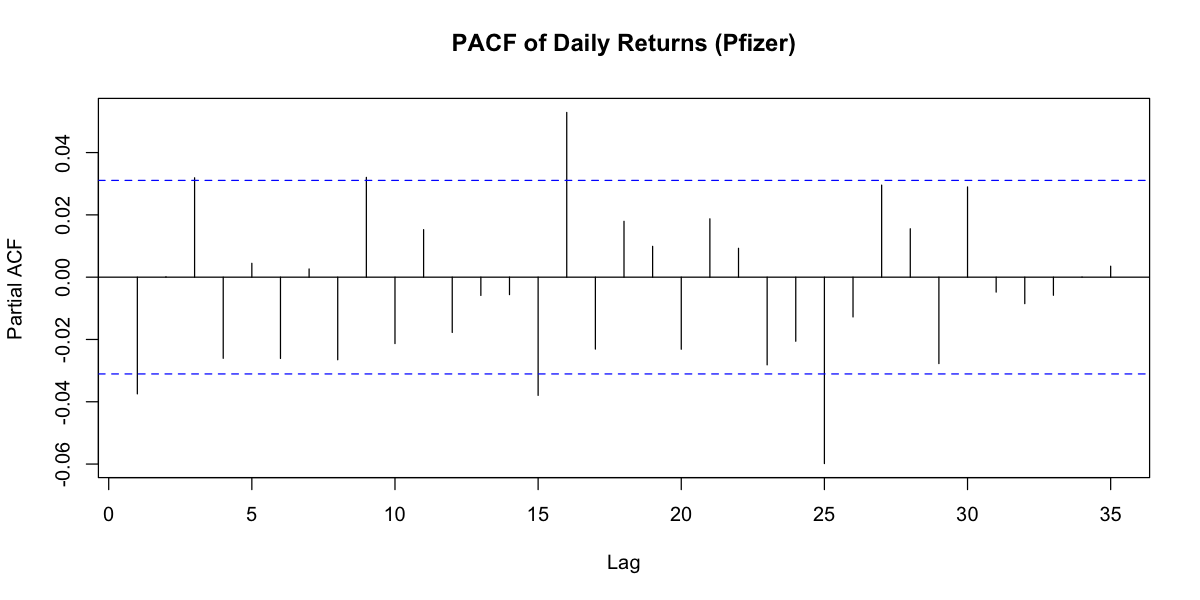

In [ ]:
# PACF plot 
#| warning: false
#| results: hide
pacf(pfe$ret, lags = 20, 
    na.action = na.omit, 
    main = "PACF of Daily Returns (Pfizer)")

We can focus in on a specific time horizon and see if autocorrelation exists within a certain timeframe. This evidence can help us to determine whether there is statistical arbitrage in which our trading strategy can detect a pattern can profit from (potentially short term momentum), as opposed to having white noise (returns which follow a strong form of the EMH where all information about the stock is reflected in its prices). We decide to focus on a relatively long horizon as it can provide us more information of how the stock's price changed before, during, and after COVID; providing us with a holistic story and finding opportunities for statistical arbitrage in the `3' phases of COVID.

Processing: WEEKLY 


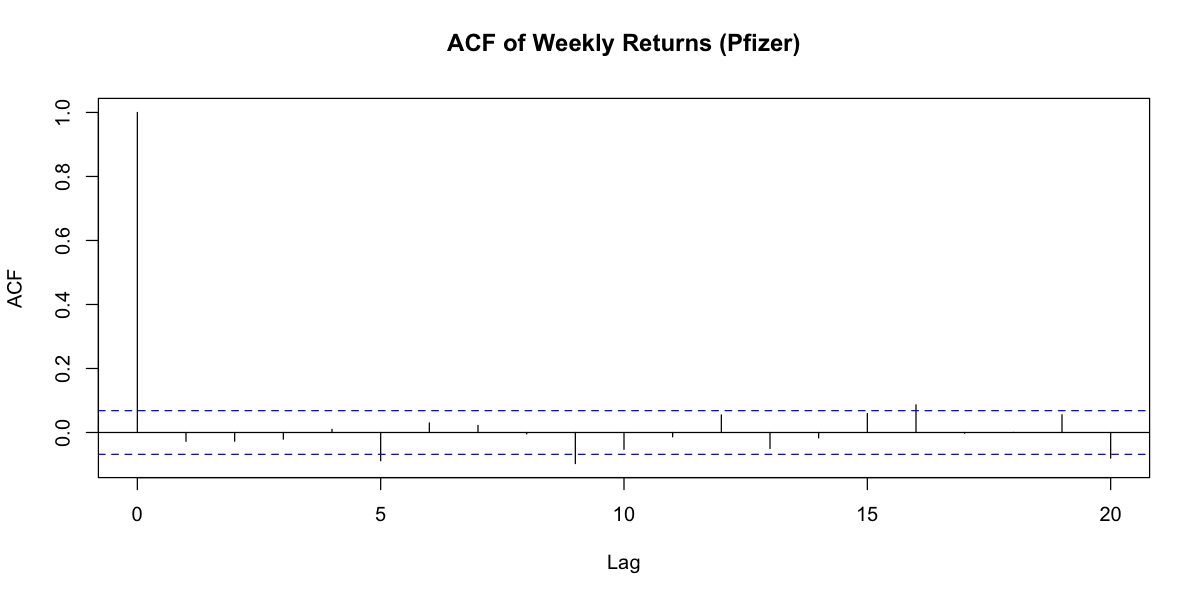

Processing: MONTHLY 


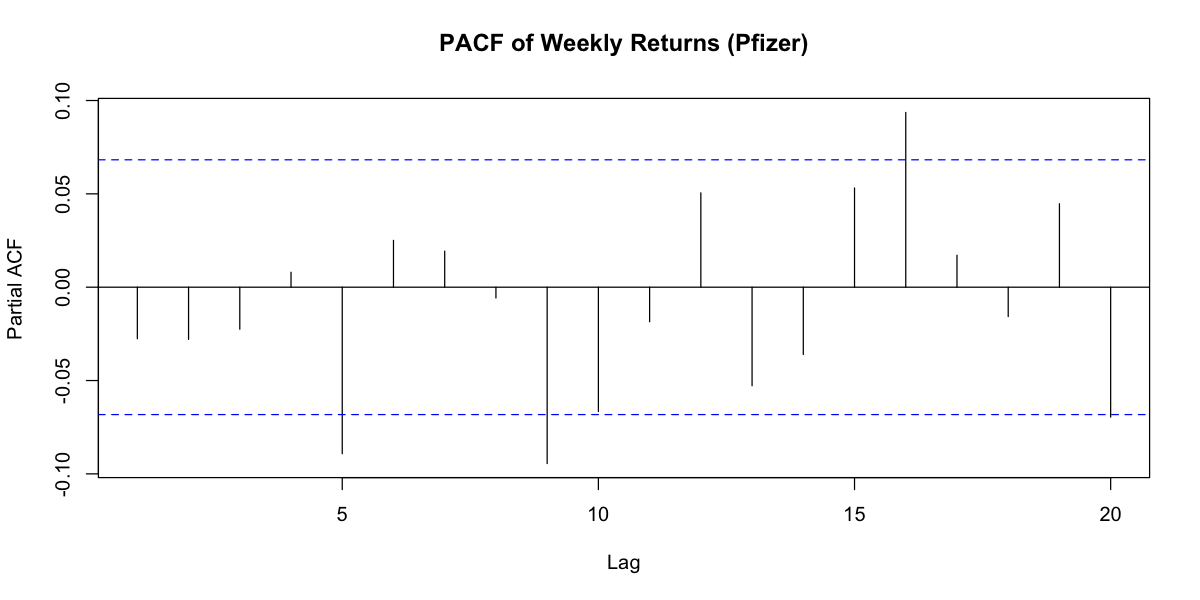

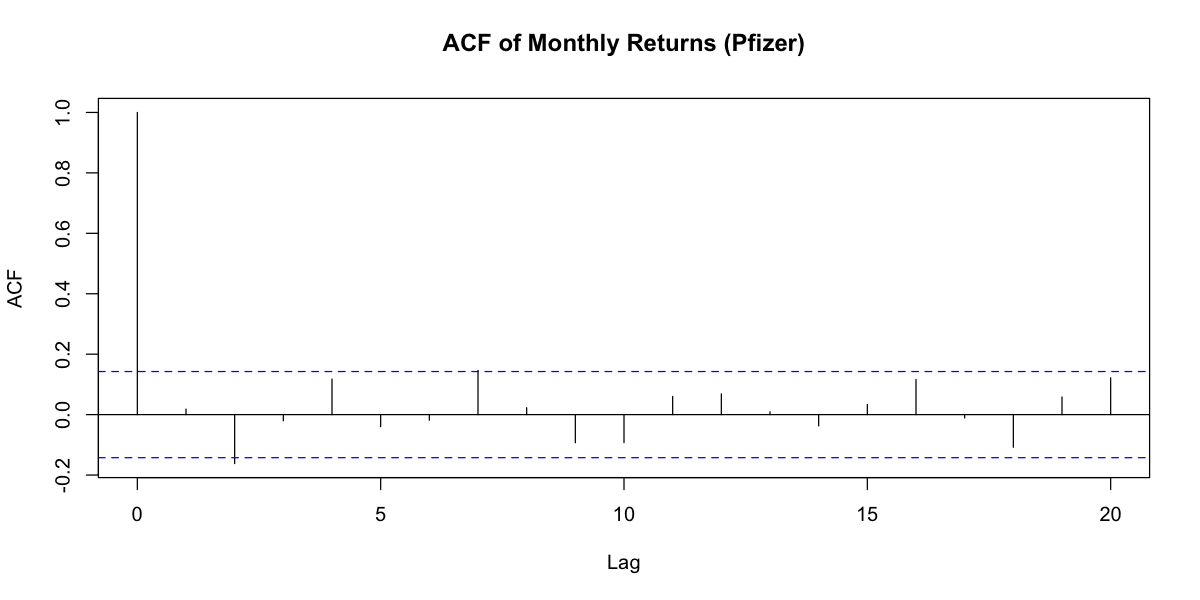

Processing: SEMI_ANNUALLY 


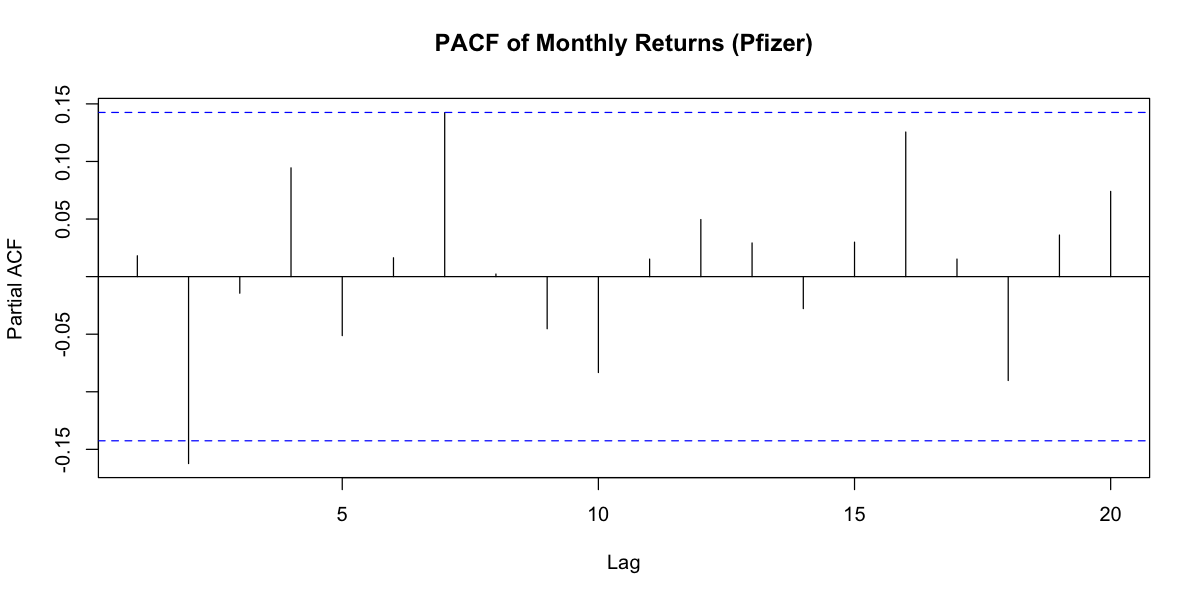

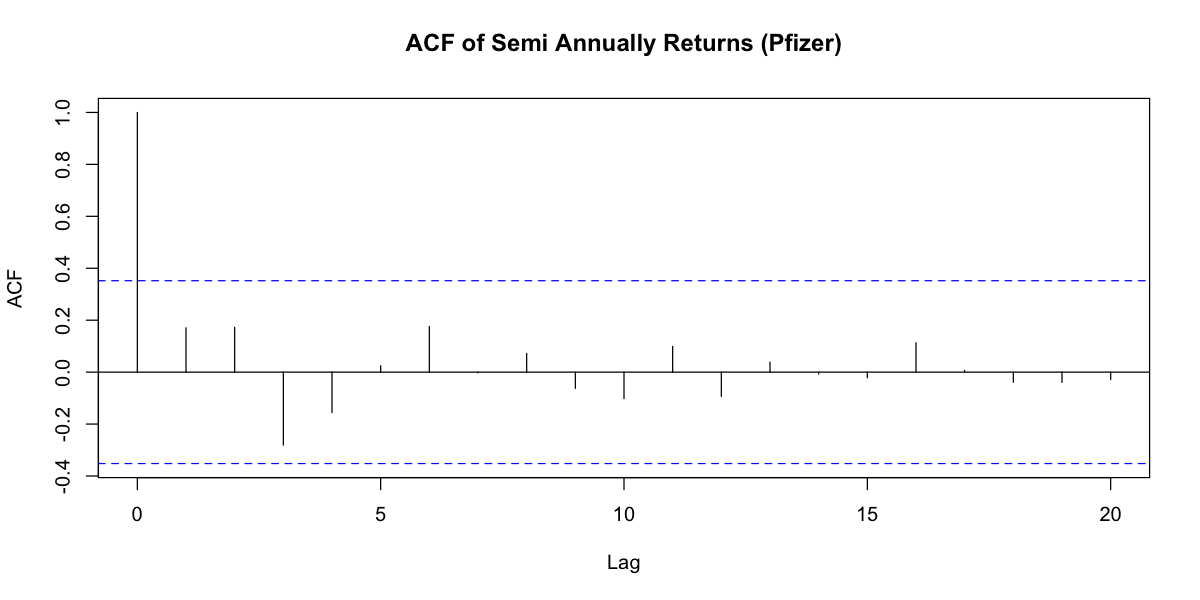

Processing: ANNUALLY 


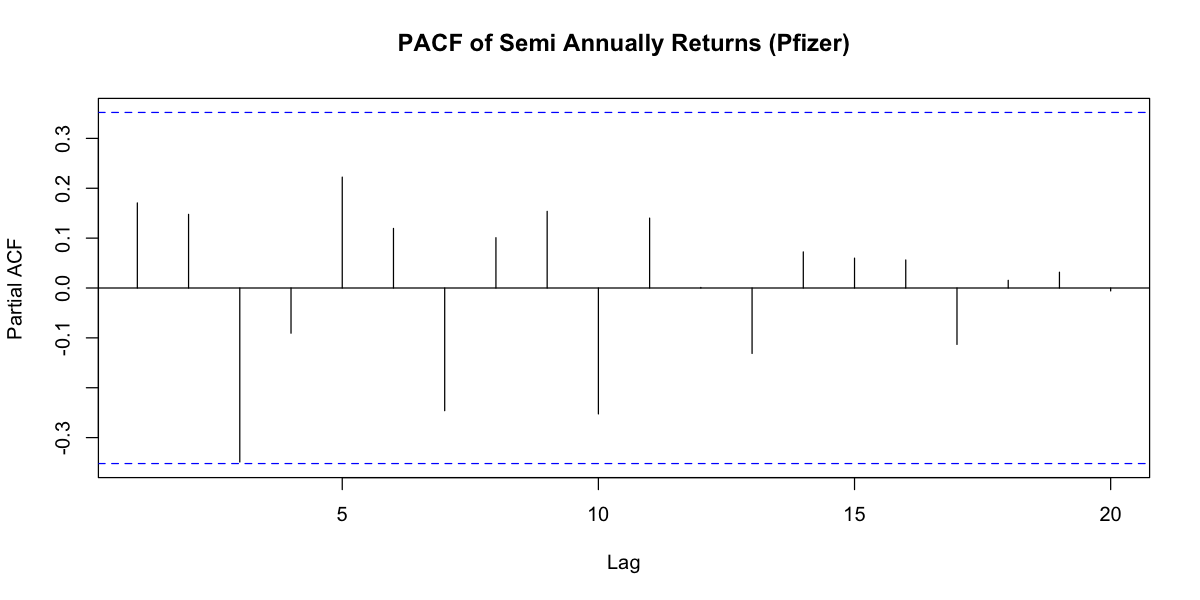

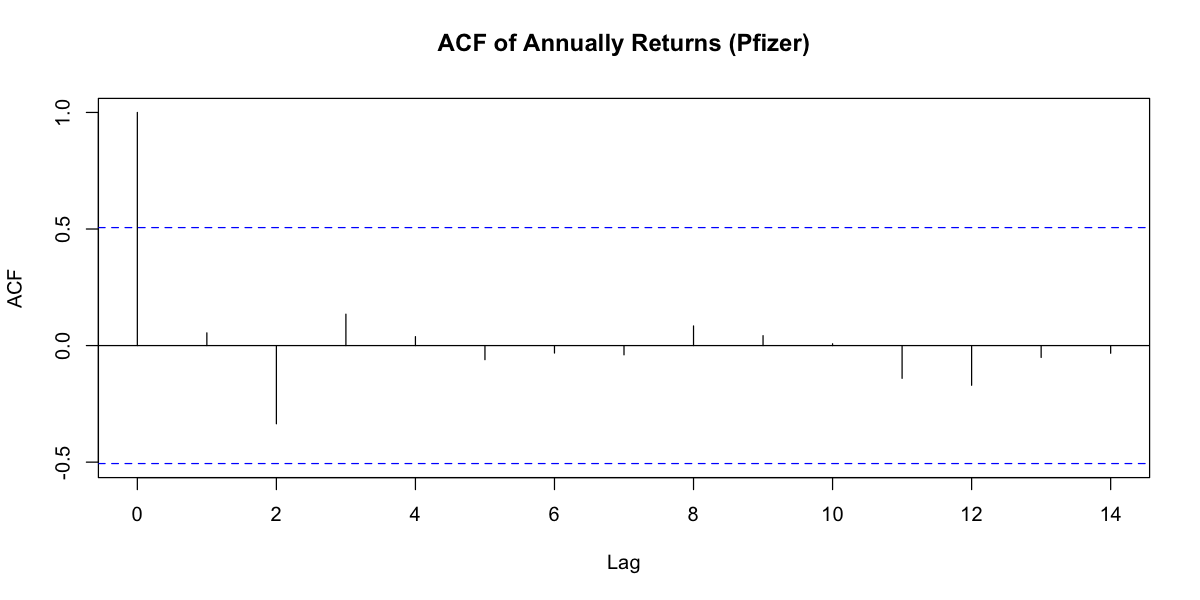

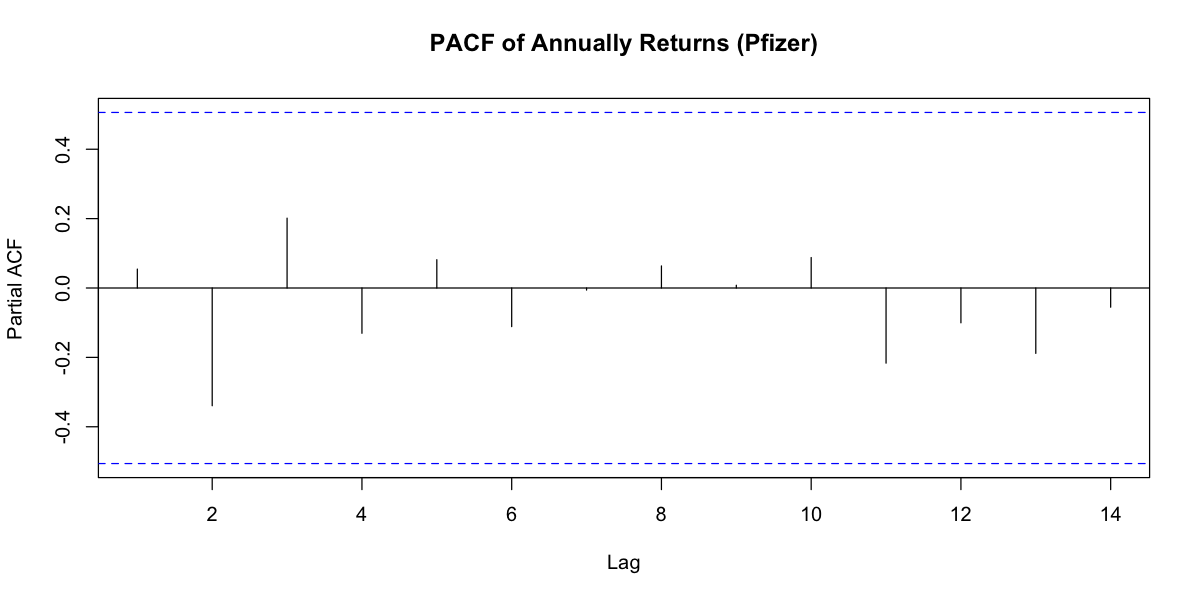

In [ ]:
#| warning: false
#| results: hide

# Create a list of periods we want to look at
periods <- list(
    weekly = "week",
    monthly = "month", 
    semi_annually = "6 months",
    annually = "year"
)

# Loop through each time period
for (period_name in names(periods)) {
    cat("Processing:", toupper(period_name), "\n")
    
    # Create proper period returns (one observation per period)
    pfe_period <- pfe %>%
        mutate(period = floor_date(datadate, periods[[period_name]])) %>%
        group_by(period) %>%
        arrange(datadate) %>%
        slice_tail(n = 1) %>%  
        ungroup() %>%
        arrange(datadate) %>%
        mutate(period_ret = (prccd / lag(prccd)) - 1) %>%
        filter(!is.na(period_ret))
    
    # View tibble (dataframe) using the following:
    # print(head(pfe_period))
    # cat("Number of periods:", nrow(pfe_period), "\n\n")
    
    # ACF of actual period returns (suppress warnings)
    suppressWarnings(
        acf(pfe_period$period_ret, lag.max = 20, 
            na.action = na.omit,
            main = paste("ACF of", 
            tools::toTitleCase(gsub("_", " ", period_name)), 
            "Returns (Pfizer)"))
    )
    
    # PACF of actual period returns (suppress warnings)
    suppressWarnings(
        pacf(pfe_period$period_ret, lag.max = 20,
             na.action = na.omit,
             main = paste("PACF of", 
             tools::toTitleCase(gsub("_", " ", period_name)), 
             "Returns (Pfizer)"))
    )
}

In [ ]:
pfe <- pfe %>%
  filter(datadate >= as.Date("2020-01-01")) %>%
  arrange(datadate)

In [ ]:
source('bs-signal.r')
source('backtest.r')

# Grids to search
fast_grid <- c(20, 30, 40, 50)
slow_grid <- c(60, 90, 120, 150)

# Store data for each combination
results <- data.frame(
  fast = integer(),
  slow = integer(),
  final_equity = numeric(),
  stringsAsFactors = FALSE
)

for (f in fast_grid) {
  for (s in slow_grid) {
    if (f >= s) next  
    
    # 1) Generate signals
    sig <- ma_signal(price, fast = f, slow = s)
    
    # 2) Backtest
    bt  <- backtest_ma(price, signal = sig)
    
    # 3) Store final equity (performance metric)
    final_eq <- tail(bt$equity, 1)
    
    results <- rbind(
      results,
      data.frame(fast = f, slow = s, final_equity = final_eq)
    )
  }
}

# Pick best-performing combination
best_idx   <- which.max(results$final_equity)
best_fast  <- results$fast[best_idx]
best_slow  <- results$slow[best_idx]
results[best_idx, ] 


,fast,slow,final_equity
,<dbl>,<dbl>,<dbl>
15,50,120,1.178767


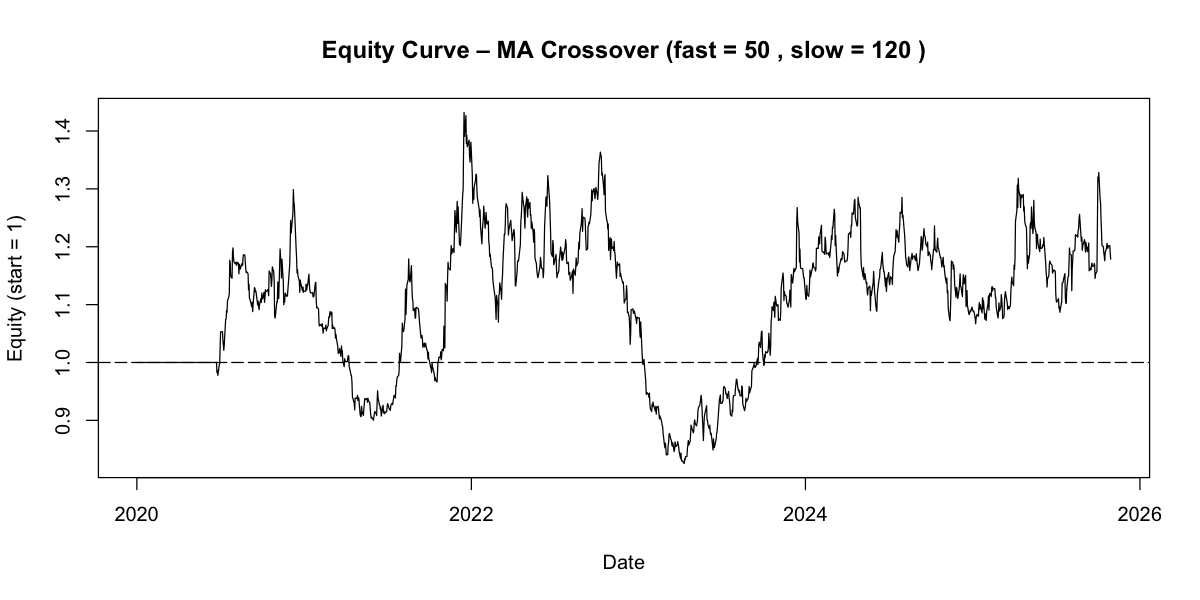

In [ ]:
price <- pfe$prccd

# Generate signals and backtest using the optimal windows
best_signal <- ma_signal(price, fast = best_fast, slow = best_slow)
best_bt     <- backtest_ma(price, signal = best_signal)

# Equity curve plot
plot(
  pfe$datadate, best_bt$equity, type = "l",
  xlab = "Date", ylab = "Equity (start = 1)",
  main = paste("Equity Curve – MA Crossover (fast =", best_fast,
               ", slow =", best_slow, ")")
)
abline(h = 1, lty = 5)  


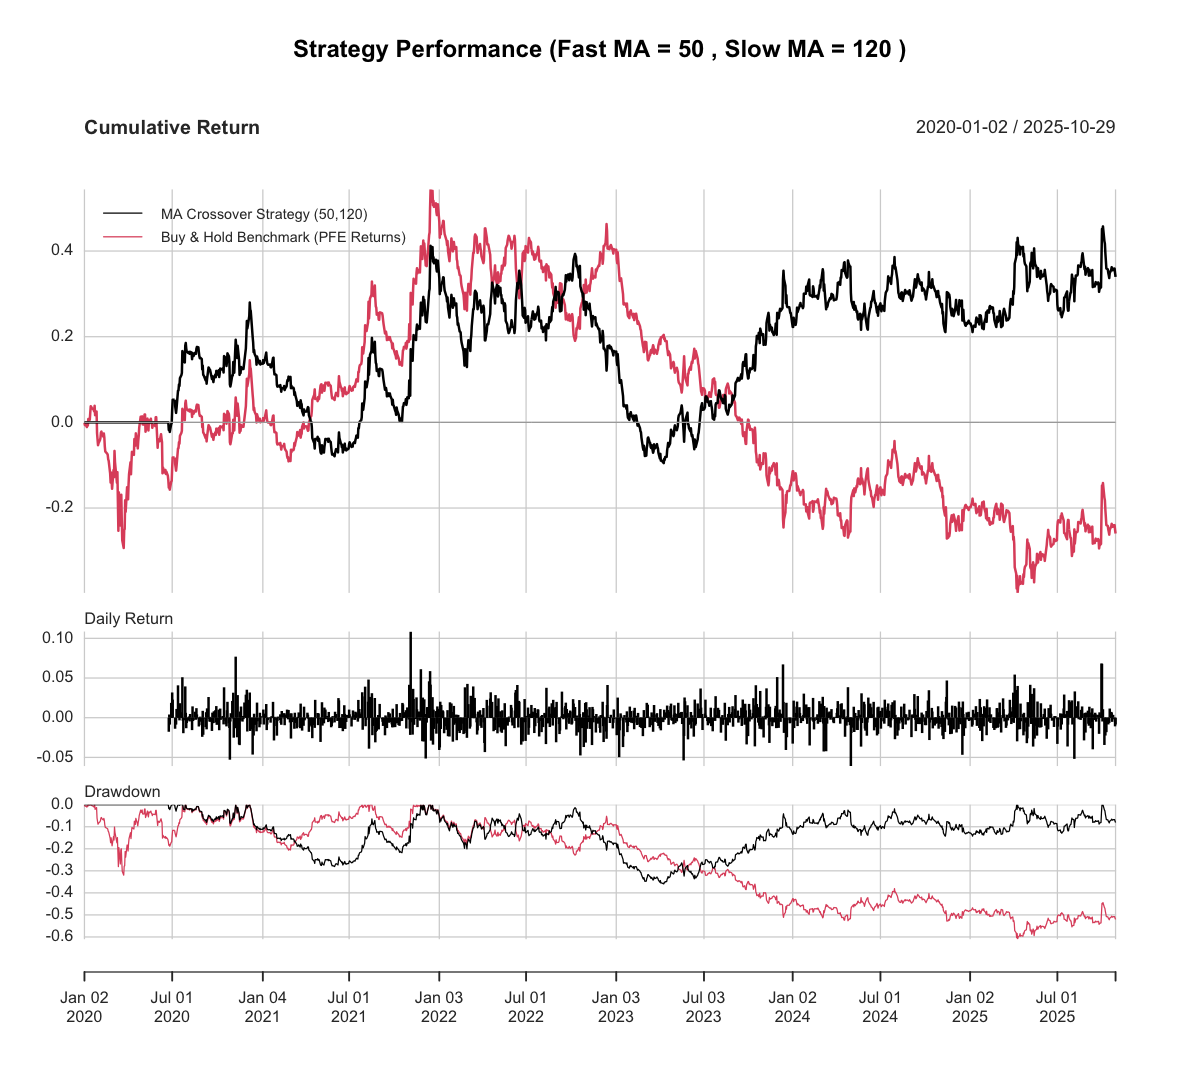

In [ ]:
# Store data in an xts readable dataframe
strategy_returns <- xts(best_bt$returns, order.by = pfe$datadate)
benchmark_returns <- xts(pfe$ret, order.by = pfe$datadate)

comparison <- merge(strategy_returns, benchmark_returns)
colnames(comparison) <- c("MA Crossover Strategy (50,120)", "Buy & Hold Benchmark (PFE Returns)")

# Performance Summary Chart
options(repr.plot.width = 10, repr.plot.height = 9) # Adjust plot dim.
charts.PerformanceSummary(
    comparison, 
    geometric = FALSE,
    main = paste("Strategy Performance (Fast MA =", 
        best_fast, ", Slow MA =", best_slow, ")")
)

# Reset to default height
options(repr.plot.width = 10, repr.plot.height = 5)

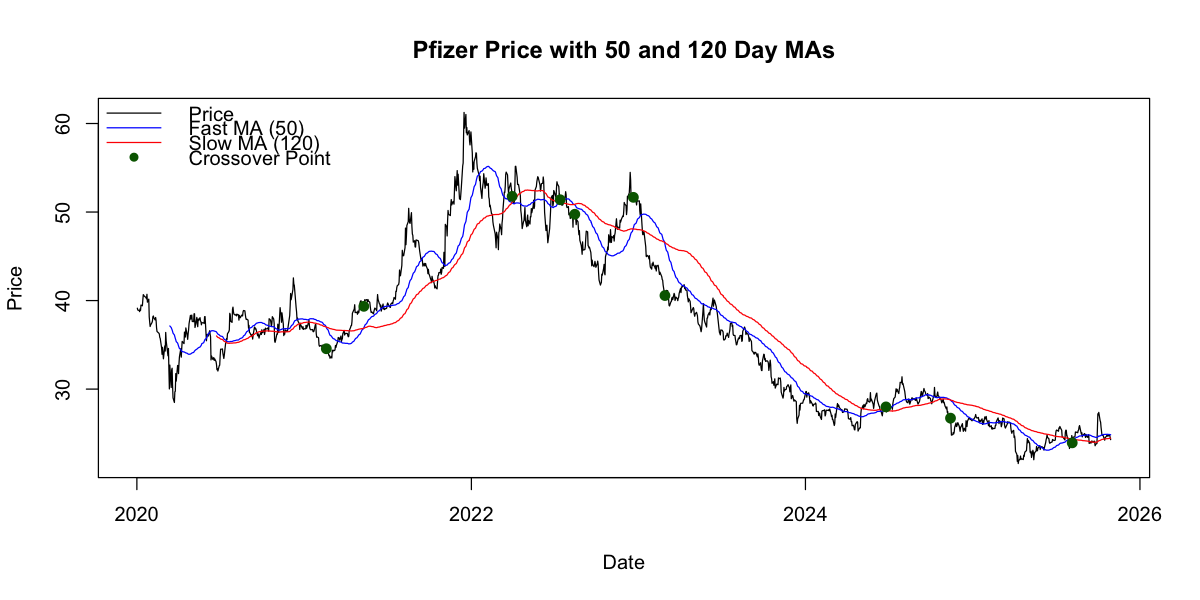

In [ ]:
# Compute moving averages for the best windows
fast_ma_best <- moving_avg(price, win_size = best_fast)
slow_ma_best <- moving_avg(price, win_size = best_slow)

# Base plot: price
plot(
  pfe$datadate, price, type = "l",
  xlab = "Date", ylab = "Price",
  main = paste("Pfizer Price with", best_fast, 
  "and", best_slow, "Day MAs")
)

# Add moving averages
lines(pfe$datadate, fast_ma_best, col = "blue")
lines(pfe$datadate, slow_ma_best, col = "red")

# Identify crossover points
spread    <- fast_ma_best - slow_ma_best
cross_idx <- which(diff(sign(spread)) != 0) + 1  

# Add crossover markers to the plot
points(
  pfe$datadate[cross_idx],    
  price[cross_idx],           
  pch = 16, col = "darkgreen", cex = 1.2
)

legend(
  "topleft",
  legend = c(
    "Price",
    paste0("Fast MA (", best_fast, ")"),
    paste0("Slow MA (", best_slow, ")"),
    "Crossover Point"
  ),
  col = c("black", "blue", "red", "darkgreen"),
  lty = c(1, 1, 1, NA),  
  pch = c(NA, NA, NA, 16),  
  bty = "n"
)

Bollinger Bands Trading Strategy (Created with GenAI)

In [ ]:
############################################################
# bollinger_strategy.R
# Bollinger Bands calculation + breakout trading signals
############################################################

# Bollinger Bands calculator -----------------------------------------
# prices : numeric vector of prices (e.g. closing prices)
# n      : lookback window for the moving average and std dev
# k      : number of standard deviations for the bands (usually 2)
bollinger_bands <- function(prices, n = 20, k = 2) {
  N <- length(prices)
  mid <- rep(NA_real_, N)
  sdv <- rep(NA_real_, N)

  if (n > N) {
    warning("Window size n is larger than length of price series.")
    return(list(
      middle = mid,
      upper  = rep(NA_real_, N),
      lower  = rep(NA_real_, N)
    ))
  }

  for (i in n:N) {
    window_vals <- prices[(i - n + 1):i]
    mid[i] <- mean(window_vals, na.rm = TRUE)
    sdv[i] <- stats::sd(window_vals, na.rm = TRUE)
  }

  upper <- mid + k * sdv
  lower <- mid - k * sdv

  return(list(
    middle = mid,
    upper  = upper,
    lower  = lower
  ))
}

# Bollinger Bands breakout signal ------------------------------------
# price : numeric vector of prices
# n     : lookback window (same as above)
# k     : number of standard deviations
#
# Strategy (breakout, trend-following):
#   price > upper band  -> go long  (+1)
#   price < lower band  -> go short (-1)
#   otherwise           -> flat     (0)
#
# This returns a vector of signals with the same length as price.
bb_signal <- function(price, n = 20, k = 2) {
  bb <- bollinger_bands(price, n = n, k = k)

  upper <- bb$upper
  lower <- bb$lower

  signal <- rep(0, length(price))

  # breakout logic
  signal[price > upper] <-  1   # long when breaking above upper band
  signal[price < lower] <- -1   # short when breaking below lower band

  return(signal)
}